In [1]:
import cv2#cv2라이브러리를 이용해서 이미지 읽어옴
import numpy as np
import os
from matplotlib import pyplot as plt
print(os.getcwd())
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\hi\Anaconda3\jupiter\day21딥러닝


In [2]:
data_dir = os.chdir(os.getcwd() + "./DL_cloth_Img/all_clothes/")

In [3]:
print(os.getcwd())

C:\Users\hi\Anaconda3\jupiter\day21딥러닝\DL_cloth_Img\all_clothes


In [4]:
import glob
from glob import glob

In [5]:
data_list = glob('*.jpg')
print('파일의 목록 개수 >> ', len(data_list))
print('파일의 목록 타입 >> ', type(data_list))

파일의 목록 개수 >>  7652
파일의 목록 타입 >>  <class 'list'>


In [6]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [7]:
#string을 특정한 기준에 의해 token으로 끊어 리스트를 리턴
token = text_to_word_sequence(data_list[0])
token, type(token)

(['blouse', '0', '1', 'jpg'], list)

In [9]:
label2 = []
for x in data_list[:7653]:
    token = text_to_word_sequence(x)
    label2.append(token[0])
len(label2)

7652

In [10]:
# 라벨 인코딩(카테고리형 문자를 숫자로 자동 변환해주는 역할)
from sklearn.preprocessing import LabelEncoder

In [11]:
encoder = LabelEncoder()
encoder = LabelEncoder()
label3 = encoder.fit_transform(label2)
label3[:5]

array([0, 0, 0, 0, 0], dtype=int64)

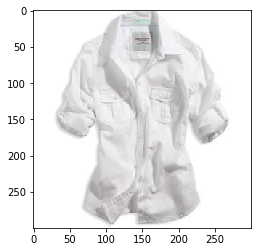

In [12]:
img0 = cv2.imread(data_list[0])
plt.imshow(img0)

In [13]:
#이미지 shape확인!(가로,세로,칼라)의미
img0.shape

(300, 300, 3)

In [14]:
data_height = 150
data_width = 150
channel_n = 3#칼라로 맞추기(흑백이면 1)칼라는 rgb3개를 고려해야하기 때문에 3이다.

In [15]:
## 이미지 표준화(0~1사이로)
## 픽셀은 0~255의 크기를 가지므로 255로 나누어서 
## 표준화를 진행해주자.(0~1사이로표시)
## 4000개의 크기를 다 변경해주세요
img_list = []#크기를 변경하고 나서의 결과를 모아주기 위한 리스트
# 7652개의 이미지 전처리(스케일링)
for x in data_list:
    #픽셀크기가(0~255)이므로 255로 나누자
    scaled_one = cv2.imread(x) / 255
    resized_one = cv2.resize(scaled_one, (data_height, data_width))
#     print('변경 전', scaled_one.shape)
#     print('변경 후', resized_one.shape)    
    img_list.append(resized_one)
len(img_list),img_list[0].shape

(7652, (150, 150, 3))

In [16]:
##data_list : 전체 이미지 목록의 리스트
##읽어온 이미지 목록을 넣으면 라벨링/이미지 스케일링/리사이징해서
##우리가 원하는 이미지 데이터를 만들자.
def make_file(data_height, data_width, channel_n, data_list_n):#len(data_list)=data_list_n
    ## 라벨링한 결과 넣어줄 리스트 필요
    label = []
    ## 4차원으로 만들어줄 4차원 리스트 필요
    images = np.zeros((data_list_n, data_height, data_width, channel_n))
    ## 이미지 리스트에서 하나씩 꺼내서 라벨링, 스케일링, 리사이징하자
    for i, image in enumerate(data_list):#i가 1씩증가,data_list에 이미지 목록 다 들어있음
        
        ## 라벨링:
        tokens = text_to_word_sequence(image)#이미지를 토큰으로 끊어주자(이런식으로)
        label.append(tokens[0])#0번째 토큰
        
        ## 읽어서, 스케일링, 리사이징해서
        image2 = cv2.imread(image)
        image3 = cv2.resize(image2,(data_height, data_width)) / 255
        
        ## 4차원 리스트에 하나씩 끼자
        images[i, :, :, :] = image3
    label2 = np.array(label)
    return label2, images

In [17]:
labels, images = make_file(data_height, data_width, channel_n, 7652)#7652개의 이미지

In [18]:
#labels에 고양인지 개인지에 대한 토큰만 담김
labels

array(['blouse', 'blouse', 'blouse', ..., 'tshirt', 'tshirt', 'tshirt'],
      dtype='<U7')

In [19]:
items = label2
encoder = LabelEncoder()
label = encoder.fit_transform(items)
label, len(label) 

(array([0, 0, 0, ..., 7, 7, 7], dtype=int64), 7652)

In [20]:
encoder.classes_

array(['blouse', 'dress', 'jacket', 'pant', 'short', 'skirt', 'sweater',
       'tshirt'], dtype='<U7')

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
## train, test데이터를 나누어보자.

In [23]:
x = images
y = label

X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size= 0.2,
                                                    random_state=55
                                                   )
print(X_train.shape, X_test.shape)

(6121, 150, 150, 3) (1531, 150, 150, 3)


In [24]:
## 딥러닝 모델을 만들어보자.
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import datasets, layers, models

In [26]:
# Pre-trained 모델 가져오기
from tensorflow.keras.applications import ResNet50
cnn_base = ResNet50(include_top=False, weights='imagenet', 
                 input_shape=[data_height, data_width, channel_n],classes=2) 

94781440/94765736 [==============================] - 10s 0us/step


In [27]:
model = Sequential()
### 특성추출 레이어를 쌓아준다.

# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(data_height, data_width, channel_n)))
# model.add(MaxPool2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPool2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))

### 딥러닝 학습 레이어를 쌓아준다.
### 입력--히든--출력 순서대로 쌓아준다.
### 입력(1개)-- 1차원이여야함.

model.add(cnn_base) 
model.add(Flatten()) ## 이미지 데이터를 1차원으로 만들어주는 객체 
### 히든
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(20, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(10, activation='relu'))
model.add(Dropout(rate=0.3))

## 출력(1개)--딥러닝으로 하는 학습의 종류에 따라 다르게 써주어야 함!
## 이진 분류인경우(1, sigmoid)
## 다중 분류인경우(1, softmax)
## 회귀인 경우(1, linear)
model.add(Dense(8, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 128)               6553728   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)               

In [28]:
## 모델의 설정값 지정
## 1. 기울기 찾는데 최적의 방법 설정(optimizer)
## 2. 특정한 가중치를 가지는 경우 오차를 계산하는 방법 설정(loss)
##    회귀인 경우: mae
##    분류인 경우: 이진=> binary_crossentropy,
##    다중분류인 경우=> sparse_categorical_crossentropy
## 3. fit시킬 때 fit시키는 상황이 순서대로 프린트되는데 출력되는 항목 설정(metrics)
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [1]:
## 공부시키자
# epoch마다 train의 loss,acc 뿐만아니라 test의 loss,acc도 알고싶어
# fit함수안에 validation_data=(X_test, y_test)를 넣어 돌려보자.
# 조기종료(earlyStopping) : 
# epoch를 실행할 때 최적의 acc인 경우, 더이상 epoch를 수행하지 않아도 되도록 설정
# 모델저장(checkPoint):
# 최적의 acc인 경우의 가중치를 자동으로 모델파일로 저장하게 설정
# 특정한 상황을 기다렸다가 특정한 처리를 하고자 하는 경우(콜백함수)
# 1)객체를 만들어주고, fit(callbacks = [객체])
cnn_history = model.fit(
    X_train,
    y_train,
    batch_size=100,
    epochs=10,
    validation_data=(X_test, y_test),
    verbose=2
)

NameError: name 'model' is not defined

In [ ]:
test_result = model.evaluate(X_test,y_test) 
test_result

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1) ## 1행2열의 도표, 1열
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('model acc.')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train_acc','test_acc'])

plt.subplot(1, 2, 2) ## 1행2열의 도표, 2열
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','test_loss'])